In [42]:
from pathlib import Path
import random
import os
import re

import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [43]:
def set_seed(seed):
    """
    Sets the random seed for reproducibility.
    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda:2")
    print("CUDA is available. Using GPU")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU


## Data

In [45]:
data_path = Path('data/ben_bucket')
pcaps = data_path.glob('**/*.pcap')
pcap_paths = pd.Series(pcaps)

In [46]:
def extract_pcap_info(path):
    p = Path(path)
    parts = p.parts
    location = parts[3]  # 4th part (traffic/location/date...)
    date_str = parts[4]  # 5th part is the date
    app = parts[5]       # 6th part is the app
    vpn_type = parts[6]   # 7th part is VPN/Non-VPN

    # Convert date to datetime
    date = pd.to_datetime(date_str, format='%Y%m%d_%H%M%S')
    
    return location, date, app, vpn_type

# Apply the function to each path in the series
df = pd.DataFrame(pcap_paths.apply(extract_pcap_info).tolist(), columns=['location', 'date', 'app', 'vpn_type'])

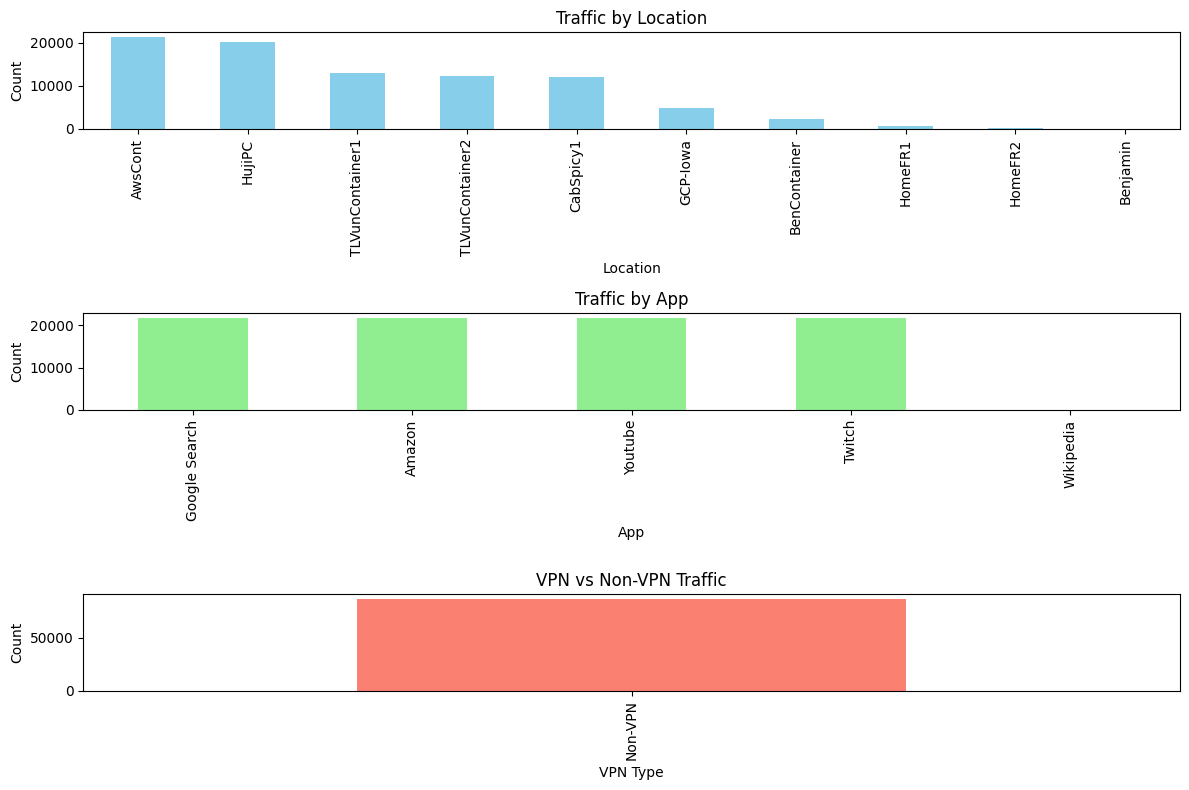

In [47]:
import matplotlib.pyplot as plt

# Create counts of locations
location_counts = df['location'].value_counts()

# Create counts of apps
app_counts = df['app'].value_counts()

# Create counts of VPN vs Non-VPN usage
vpn_counts = df['vpn_type'].value_counts()

# Plotting the data
plt.figure(figsize=(12, 8))

# Plot 1: Location Distribution
plt.subplot(3, 1, 1)
location_counts.plot(kind='bar', color='skyblue')
plt.title('Traffic by Location')
plt.xlabel('Location')
plt.ylabel('Count')

# Plot 2: App Distribution
plt.subplot(3, 1, 2)
app_counts.plot(kind='bar', color='lightgreen')
plt.title('Traffic by App')
plt.xlabel('App')
plt.ylabel('Count')

# Plot 3: VPN vs Non-VPN Traffic
plt.subplot(3, 1, 3)
vpn_counts.plot(kind='bar', color='salmon')
plt.title('VPN vs Non-VPN Traffic')
plt.xlabel('VPN Type')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.savefig('tmp1.png')


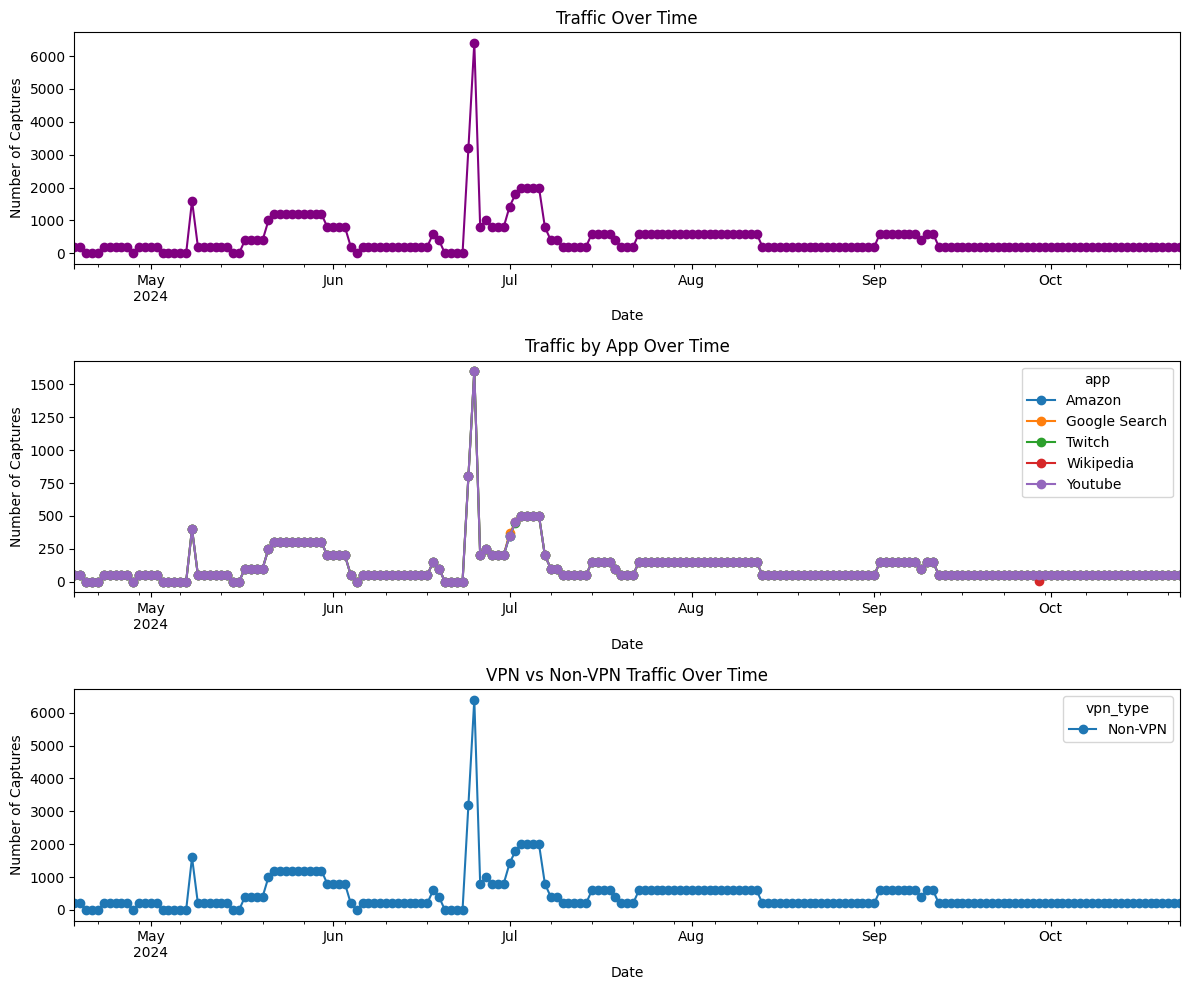

In [48]:
# Additional analysis: traffic over time and by app with VPN vs Non-VPN
plt.figure(figsize=(12, 10))

# Plot 1: Traffic over time
plt.subplot(3, 1, 1)
df.set_index('date').resample('D').size().plot(kind='line', marker='o', color='purple')
plt.title('Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Captures')

# Plot 2: Traffic by app over time
plt.subplot(3, 1, 2)
df.set_index('date').groupby('app').resample('D').size().unstack('app').plot(kind='line', marker='o', ax=plt.gca())
plt.title('Traffic by App Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Captures')

# Plot 3: VPN vs Non-VPN Traffic over time
plt.subplot(3, 1, 3)
df.set_index('date').groupby('vpn_type').resample('D').size().unstack('vpn_type').plot(kind='line', marker='o', ax=plt.gca())
plt.title('VPN vs Non-VPN Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Captures')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.savefig('tmp2.png')


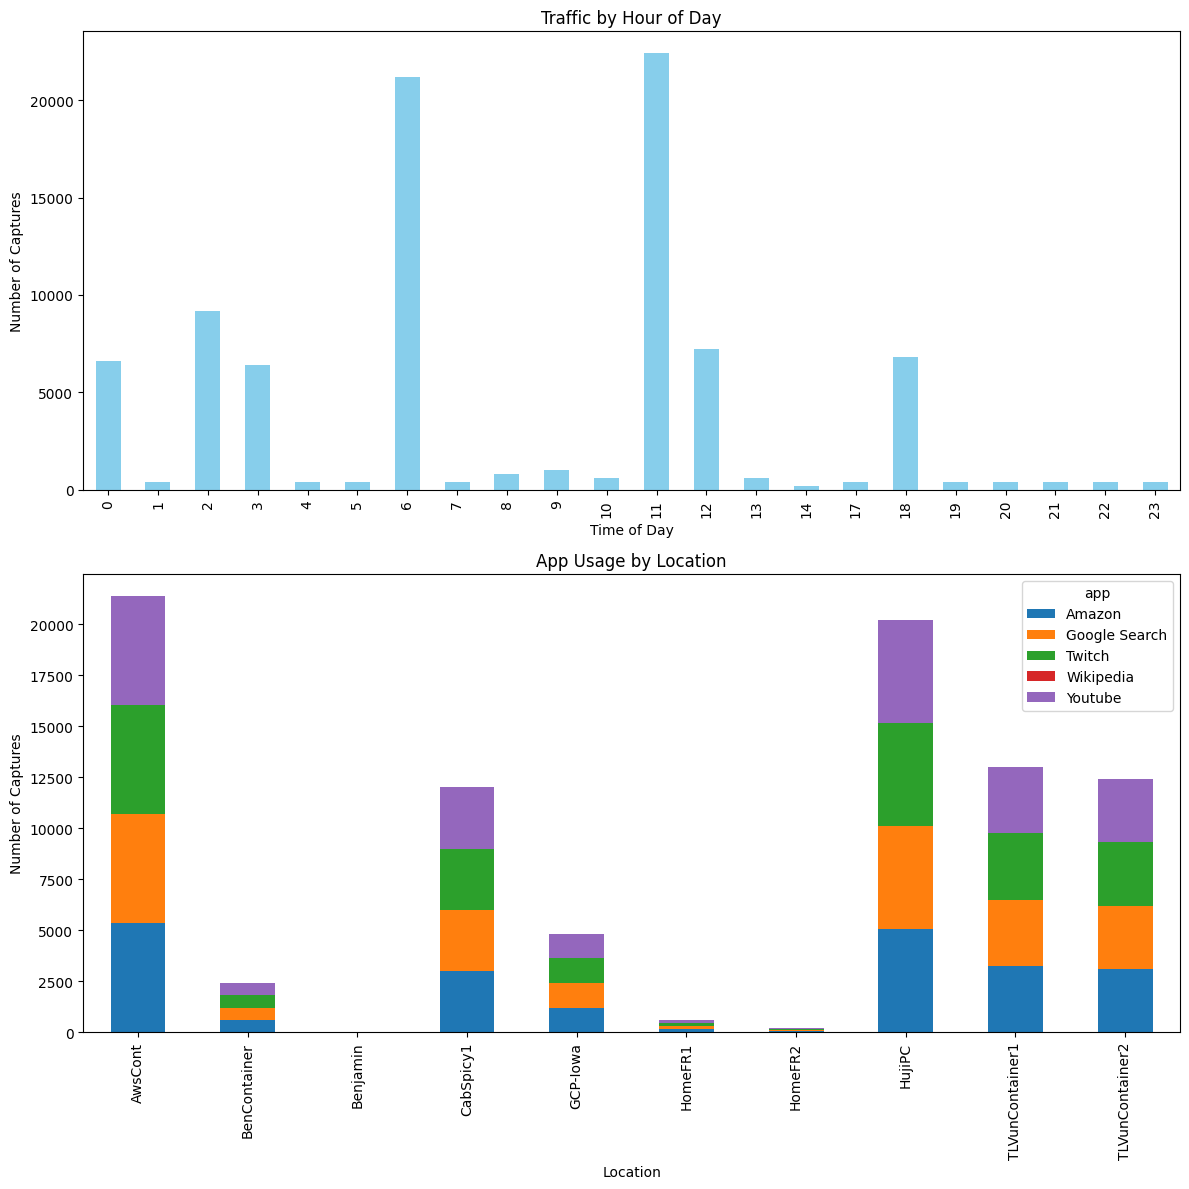

In [49]:
# Extracting the hour of the day to analyze traffic patterns by time of day
df['hour'] = df['date'].dt.hour
plt.figure(figsize=(12, 12))

# Plot 1: Traffic by time of day
plt.subplot(2, 1, 1)
df['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Traffic by Hour of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Captures')

# Plot 3: App usage by location
plt.subplot(2, 1, 2)
location_app_counts = df.groupby(['location', 'app']).size().unstack('app', fill_value=0)
location_app_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('App Usage by Location')
plt.xlabel('Location')
plt.ylabel('Number of Captures')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('tmp3.png')


## Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split

# Number of classes based on the LABELS list
num_classes = len(LABELS)  # This will be the output size of the model
learning_rate = 1e-3

class TrafficCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(TrafficCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=10, stride=5, padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=10, stride=5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(20 * 15 * 15, 64)  # Adjust the dimensions if needed
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 20 * 15 * 15)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Multi-class classification

# Create train and validation split
# dataset = FlowPicDataset(pcap_dir)  # Assuming this is your dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Model initialization
model = TrafficCNN(num_classes=num_classes)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Training loop
def train(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs.unsqueeze(1))  # Add channel dimension for Conv2D
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # CrossEntropyLoss expects class indices, not one-hot
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.unsqueeze(1))  # Add channel dimension for Conv2D
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')

# Running the training
train(model, train_loader, val_loader, num_epochs)


KeyboardInterrupt



In [ ]:
import os

# Define the structure and file contents based on the notebook
flowpic_dir = 'FlowPic'

# Ensure the directory for FlowPic exists
os.makedirs(flowpic_dir, exist_ok=True)

# Split the code into different files and modules for a Python package structure
# File: FlowPic/utils.py (contains set_seed and device setup)

utils_py = """
import random
import numpy as np
import torch

def set_seed(seed):
    \"\"\"
    Sets the random seed for reproducibility.
    Args:
        seed (int): The seed value to set.
    \"\"\"
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:2")
        print("CUDA is available. Using GPU")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")
    return device
"""

with open(os.path.join(flowpic_dir, 'utils.py'), 'w') as f:
    f.write(utils_py)

# File: FlowPic/model.py (contains model definition)

model_py = """
import torch.nn as nn
import torch.nn.functional as F

class FlowPicCNN(nn.Module):
    def __init__(self, num_classes):
        super(FlowPicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)  # Adjust based on input image size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 37 * 37)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
"""

with open(os.path.join(flowpic_dir, 'model.py'), 'w') as f:
    f.write(model_py)

# File: FlowPic/train.py (contains training and validation logic)

train_py = """
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, train_loader, val_loader, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.unsqueeze(1))  # Add channel dimension for Conv2D
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # CrossEntropyLoss expects class indices

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.unsqueeze(1))  # Add channel dimension for Conv2D
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')
"""

with open(os.path.join(flowpic_dir, 'train.py'), 'w') as f:
    f.write(train_py)

# Main script: main.py

main_py = """
import torch
from torch.utils.data import DataLoader, TensorDataset
from FlowPic.utils import set_seed, get_device
from FlowPic.model import FlowPicCNN
from FlowPic.train import train

def main():
    # Set the seed
    set_seed(42)

    # Get the device (GPU or CPU)
    device = get_device()

    # Assuming data is loaded somewhere here (train_loader, val_loader)
    # Example:
    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize the model and move it to the device
    num_classes = 10  # Adjust based on your problem
    model = FlowPicCNN(num_classes).to(device)

    # Run training
    num_epochs = 10  # Adjust as needed
    train(model, train_loader, val_loader, num_epochs, device)

if __name__ == "__main__":
    main()
"""

# Save the main.py file
with open('main.py', 'w') as f:
    f.write(main_py)

# Notify the user that files are created
"Files have been successfully created in the FlowPic directory and main.py."
